### Background

In the field of machine learning, hyperparameter optimization is a critical task that has been studied by numerous researchers. One major challenge in HPO problems is predicting the predictive performance for unknown hyperparameters. In this article, we investigate whether PS-Forest is useful for the HPO performance prediction task and compare it to other algorithms such as XGBoost and Gaussian Process.

### Dataset Preparation
In our experiment, we first prepare experimental data by randomly sampling 1000 hyperparameter configurations from the HPO-Bench search space, and then we compute the validation score using the HPO-Bench training protocol. The real-world dataset used for training XGBoost is "kr-vs-kp". Our goal is to see if our algorithm can accurately predict the performance of new hyperparameters based on previous hyperparameter optimization data.


In [42]:
import random

import numpy as np
import pandas as pd
from numba import njit

data = pd.read_csv('https://raw.githubusercontent.com/hengzhe-zhang/EvolutionaryForest/master/data/XGB_HPO_data.csv',
                   index_col=0)
for c in ['eta', 'min_child_weight', 'reg_alpha', 'reg_lambda']:
    data[c] = np.log(data[c])

x = np.array(data[['colsample_bylevel', 'colsample_bytree', 'eta', 'max_depth',
                   'min_child_weight', 'reg_alpha',
                   'reg_lambda', 'subsample_per_it']])
y = np.array(data['function_value'])

### Evolutionary Forest vs State-of-the-art Machine Learning Algorithms
First, we can compare the test performance of evolutionary forest versus classical machine learning algorithms. The following results show that evolutionary forest achieves a testing $R^2$ score up to 0.82, while the best base line model (ET) only achieves a test score of 0.81.

In [43]:
from evolutionary_forest.forest import EvolutionaryForestRegressor
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor


@njit(cache=True)
def numba_seed(a):
    random.seed(a)
    np.random.seed(a)


random.seed(0)
np.random.seed(0)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=0)
model = EvolutionaryForestRegressor(max_height=3, min_height=1,
                                    normalize=False, select='AutomaticLexicase', ensemble_size=100,
                                    basic_primitives='add,subtract,multiply,analytical_quotient,protect_sqrt,analytical_loge,maximum',
                                    mutation_scheme='EDA-Terminal-PM',
                                    semantic_diversity='GreedySelection-Resampling', initial_tree_size='1-2',
                                    cross_pb=0.9, mutation_pb=0.1, gene_num=10, n_gen=30,
                                    n_pop=200, base_learner='Fast-RidgeDT')
ef = model.fit(x_train, y_train)
print('Testing Score (EF)', r2_score(y_test, ef.predict(x_test)))

Testing Score (EF) 0.8297590778519474


In [44]:
scores_base = []

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=0)
data_columns = ['CBL', 'CBT', 'ETA', 'MD',
                'MCW', 'RA', 'RL', 'SS']
models = ['Ridge', 'GPR', 'RF', 'ET', 'AdaBoost', 'GBDT', 'XGBoost', 'LightGBM']
for model_name in models:
    model = {
        'Ridge': Ridge(),
        'GPR': Pipeline([
            ('Scaler', StandardScaler()),
            ('GP', GaussianProcessRegressor(kernel=Matern(), normalize_y=True))
        ]),
        'RF': RandomForestRegressor(n_estimators=100),
        'ET': ExtraTreesRegressor(n_estimators=100),
        'AdaBoost': AdaBoostRegressor(n_estimators=100),
        'GBDT': GradientBoostingRegressor(n_estimators=100),
        'XGBoost': XGBRegressor(n_estimators=100, n_jobs=1),
        'LightGBM': LGBMRegressor(n_estimators=100, n_jobs=1),
    }[model_name]

    model = model.fit(x_train, y_train)
    base_score = r2_score(y_test, model.predict(x_test))
    print(model_name, 'Testing Score (Original Features)', base_score)
    scores_base.append((model_name, base_score))

Ridge Testing Score (Original Features) 0.5025937996052494
GPR Testing Score (Original Features) 0.6444684197346049
RF Testing Score (Original Features) 0.7934533571378497
ET Testing Score (Original Features) 0.8077266658537825
AdaBoost Testing Score (Original Features) 0.7373594002501026
GBDT Testing Score (Original Features) 0.8008603697704001
XGBoost Testing Score (Original Features) 0.7592136949409248
LightGBM Testing Score (Original Features) 0.7452346036940227


### Feature Importance Map

However, only achieve the best accuracy is not enough. We hope to gain more insights in addition to achieve the excellent performance. Fortunately, we can obtain a feature importance map from Evolutionary Forest.

Based on the feature importance map, it is clear that features $Max(MCW,RA)$ and $\frac{Max(MCW,RA)}{SS}$ are very important for evolutionary forest. These features are used to control the magnitude regularization. Thus, it is no wonder there features are important in predicting the performance of EF.

Nonetheless, on interesting thing is that evolutionary forest is able to discover a high order feature $Max(MCW,RA)$. This term means that the maximum of min_child_weight and reg_alpha will determine the generalization performance of XGBoost. In fact, this is perfectly true. If either min_child_weight or reg_alpha is large, the remaining term will not have an impact on regularization. Thus, the maximum of these two terms is useful for predicting the predictive performance of XGBoost.

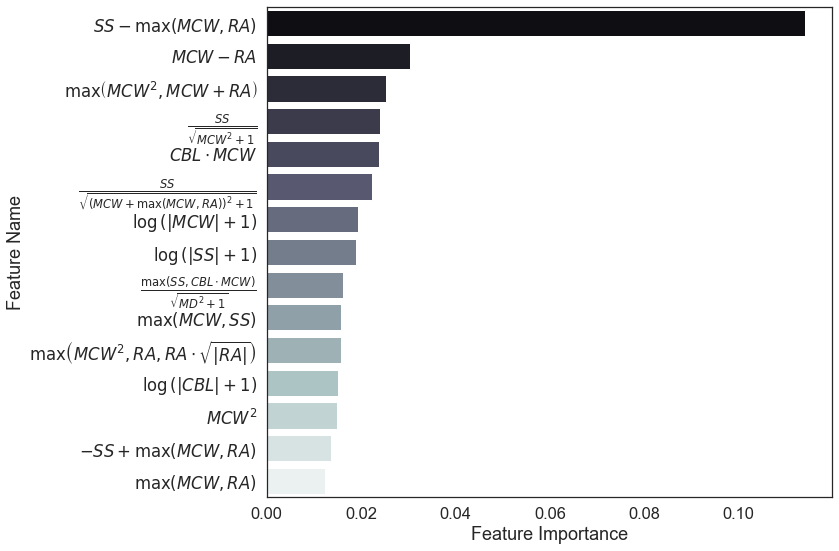

In [45]:
from evolutionary_forest.utils import get_feature_importance, plot_feature_importance

"""
Mapping:
{'colsample_bylevel': 'CBL',
 'colsample_bytree': 'CBT',
 'eta': 'ETA',
 'max_depth': 'MD',
 'min_child_weight': 'MCW',
 'reg_alpha': 'RA',
 'reg_lambda': 'RL',
 'subsample_per_it': 'SS'}
"""
feature_importance_dict = get_feature_importance(ef, latex_version=True)
for k, v in list(feature_importance_dict.items()):
    del feature_importance_dict[k]
    for i in range(len(data_columns) - 1, -1, -1):
        k = k.replace("X_{%d}" % i, data_columns[i])
    feature_importance_dict[k] = v
plot_feature_importance(feature_importance_dict, save_fig=True)

### Applying constructed features to the model
Based on the above analysis, we add two constructed features to our data, and then re-train previous machine learning models. The following experimental results show that only adding these two features can improve the predictive performance on all models, including tree-based models and linear regression models. Based on these results, we can conclude that evolutionary forest is a promising method not only for getting a better prediction model, but also helpful for getting some insights to improve existing machine learning models.

In [46]:
scores_enhanced = []

for model_name in models:
    model = {
        'Ridge': Ridge(),
        'GPR': Pipeline([
            ('Scaler', StandardScaler()),
            ('GP', GaussianProcessRegressor(kernel=Matern(), normalize_y=True))
        ]),
        'RF': RandomForestRegressor(n_estimators=100),
        'ET': ExtraTreesRegressor(n_estimators=100),
        'AdaBoost': AdaBoostRegressor(n_estimators=100),
        'GBDT': GradientBoostingRegressor(n_estimators=100),
        'XGBoost': XGBRegressor(n_estimators=100, n_jobs=1),
        'LightGBM': LGBMRegressor(n_estimators=100, n_jobs=1),
    }[model_name]

    c1 = np.max([x[:, data_columns.index('MCW')], x[:, data_columns.index('RA')]], axis=0)
    c2 = x[:, data_columns.index('MCW')] / x[:, data_columns.index('SS')]
    x_enhanced = np.concatenate([x, c1.reshape(-1, 1), c2.reshape(-1, 1)], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x_enhanced, y, test_size=0.9, random_state=0)
    model = model.fit(x_train, y_train)
    enhanced_score = r2_score(y_test, model.predict(x_test))
    print('Testing Score (Constructed Features)', enhanced_score)
    scores_enhanced.append((model_name, enhanced_score))

Testing Score (Constructed Features) 0.6852728340463523
Testing Score (Constructed Features) 0.787962820564426
Testing Score (Constructed Features) 0.830414346094692
Testing Score (Constructed Features) 0.854022108654779
Testing Score (Constructed Features) 0.7916375443540105
Testing Score (Constructed Features) 0.8087528127602583
Testing Score (Constructed Features) 0.7876440826723534
Testing Score (Constructed Features) 0.8020731707598132


              Score
Algorithm          
AdaBoost   0.737359
ET         0.807727
GBDT       0.800860
GPR        0.644468
LightGBM   0.745235
RF         0.793453
Ridge      0.502594
XGBoost    0.759214
              Score
Algorithm          
AdaBoost   0.791638
ET         0.854022
GBDT       0.808753
GPR        0.787963
LightGBM   0.802073
RF         0.830414
Ridge      0.685273
XGBoost    0.787644
              Score
Algorithm          
AdaBoost   0.054278
ET         0.046295
GBDT       0.007892
GPR        0.143494
LightGBM   0.056839
RF         0.036961
Ridge      0.182679
XGBoost    0.028430
['g' 'g' 'g' 'g' 'g' 'g' 'g' 'g']


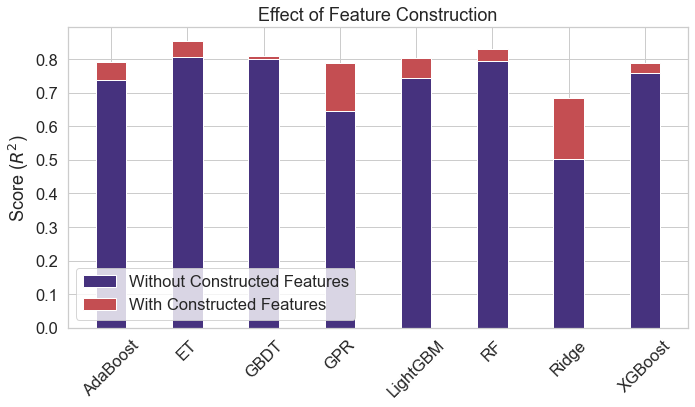

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Score aggregation
base_frame = pd.DataFrame(scores_base, columns=['Algorithm', 'Score'])
base_frame['Score'] = pd.to_numeric(base_frame['Score'])
print(base_frame.groupby(['Algorithm']).mean())
improved_frame = pd.DataFrame(scores_enhanced, columns=['Algorithm', 'Score'])
improved_frame['Score'] = pd.to_numeric(improved_frame['Score'])
print(improved_frame.groupby(['Algorithm']).mean())
base_score = base_frame.groupby(['Algorithm']).mean()
improved_score = improved_frame.groupby(['Algorithm']).mean()
print(improved_score - base_score)

sns.set(style="whitegrid", font_scale=1.5)
sns.set_palette('viridis')
width = 0.4
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(base_score.index, base_score['Score'], width, label='Without Constructed Features')
difference = improved_score['Score'] - base_score['Score']
print(np.where(difference > 0, 'g', 'y'))
ax.bar(base_score.index, difference, width, bottom=base_score['Score'],
       label='With Constructed Features',
       color=np.where(difference > 0, 'r', 'y'))
ax.set_ylabel('Score ($R^2$)')
ax.set_title('Effect of Feature Construction')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Using Constructed Features for Learning To Rank
In AutoML domain, some experts may prefer learning to rank (LTR) technique rather than regression technique because they claim that the relative order of different hyperparameter settings is more important than the specific value. This is an emerging trend, but still have not been fully adopted. In many AutoML algorithms, traditional regression techniques, especially Gaussian Process, is still widely adopted.

No matter what, our constructed feature can also be used for enhancing LTR model. Here, we try to construct a LTR model based on XGB. This XGB model is different from the previous one, because the objective function of this model is pairwise loss instead of mean squared error, which is more suitable for LTR.

From the experimental results, we can see that the spearman correlation coefficient of the model constructed from original features is 0.87. After adding two constructed features, it increases to 0.90, which demonstrates the validity of feature construction.

In [50]:
from scipy.stats import spearmanr, kendalltau

model = XGBRegressor(objective='rank:pairwise', n_estimators=100, n_jobs=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=0)
model = model.fit(x_train, y_train)
print('XGBoost', 'Testing Spearman Score (Original Features)', spearmanr(y_test,model.predict(x_test))[0])
print('XGBoost', 'Testing Kendall Score (Original Features)', kendalltau(y_test,model.predict(x_test))[0])

XGBoost Testing Spearman Score (Original Features) 0.873257433709982
XGBoost Testing Kendall Score (Original Features) 0.6933686135581842


In [49]:
c1 = np.max([x[:, data_columns.index('MCW')], x[:, data_columns.index('RA')]], axis=0)
c2 = x[:, data_columns.index('MCW')] / x[:, data_columns.index('SS')]
x_enhanced = np.concatenate([x, c1.reshape(-1, 1), c2.reshape(-1, 1)], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_enhanced, y, test_size=0.9, random_state=0)
model = model.fit(x_train, y_train)
print('XGBoost', 'Testing Spearman Score (Original Features)', spearmanr(y_test,model.predict(x_test))[0])
print('XGBoost', 'Testing Kendall Score (Original Features)', kendalltau(y_test,model.predict(x_test))[0])

XGBoost Testing Spearman Score (Original Features) 0.9024227755630321
XGBoost Testing Kendall Score (Original Features) 0.729931466678443
